# EMNIST digit CNN (BALANCED)- 10 class

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
#sns.set(style='white', context='notebook', palette='deep')
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Dense, Flatten, Convolution2D, MaxPooling2D, Dropout, AveragePooling2D
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
from keras.callbacks import EarlyStopping, ModelCheckpoint# early stopping

/home/jamil/anaconda2/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline
import tensorflow as tf
import keras
import numpy as np
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam as Adam
from keras.layers.advanced_activations import LeakyReLU
# used to save and load training histories
import pickle
from collections import defaultdict

import resource, sys

# we would reach recursion limit when saving training history otherwise
resource.setrlimit(resource.RLIMIT_STACK, (2**29,-1))
sys.setrecursionlimit(2**29 - 1)
from scipy import io as spio
emnist = spio.loadmat("/media/jamil/SSD SUPER FAST/zubayer vai/thesis/tensorflow/exmnist/matlab/emnist-digits.mat")

In [3]:
# load training dataset
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]
# load test dataset
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]
# store labels for visualization
train_labels = y_train
test_labels = y_test

In [4]:
print x_train.shape
print y_train.shape
# normalize
x_train /= 255
x_test /= 255

(240000, 784)
(240000, 1)


In [5]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
# reshape using matlab order
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28, order="A")
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28, order="A")
print x_train.shape
print y_train.shape
print x_test.shape
print y_test.shape

(240000, 1, 28, 28)
(240000, 1)
(40000, 1, 28, 28)
(40000, 1)


In [7]:
# labels should be onehot encoded
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print y_train.shape
print y_test.shape

(240000, 10)
(40000, 10)


6


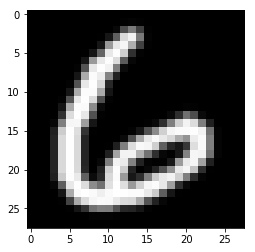

In [8]:
# which sample to look at
samplenum = 332
import matplotlib.pyplot as plt

img = x_train[samplenum]

# visualize image
plt.imshow(img[0], cmap='gray')
# show label for sample image
print train_labels[samplenum][0]

In [9]:
test_labels.shape

(40000, 1)

In [10]:
test_labels = test_labels.reshape(40000)

In [11]:
test_labels.shape

(40000,)

In [12]:
# calculate mean and standard deviation
mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)

In [13]:
# function to normalize input data
def norm_input(x): return (x-mean_px)/std_px

In [14]:
batch_size=512
inp = Input(shape=(1, 28, 28)) # N.B. TensorFlow back-end expects channel dimension last
conv_1 = Convolution2D(64, (5,5), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', data_format='channels_first')(inp)
conv_2 = Convolution2D(64, (5,5), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', data_format='channels_first')(conv_1)
pool_1 = MaxPooling2D(pool_size=(2,2), data_format='channels_first')(conv_2)
drop_1 = Dropout(0.25)(pool_1)
conv_3 = Convolution2D(128, (3,3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', data_format='channels_first')(drop_1)
conv_4 = Convolution2D(128, (3,3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', data_format='channels_first')(conv_3)
pool_2 = MaxPooling2D(pool_size=(2,2),strides=(2,2), data_format='channels_first')(conv_4)
drop_2 = Dropout(0.25)(pool_2)
flat = Flatten()(drop_2)
hidden = Dense(1024, activation='relu')(flat) # Hidden ReLU layer
drop = Dropout(0.5)(hidden)
out = Dense(10, activation='softmax')(drop) # Output softmax layer

model = Model(inputs=inp, outputs=out)

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
model.summary()
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# With data augmentation to prevent overfitting (accuracy 0.99286)



datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        data_format='channels_first')  # randomly flip images


datagen.fit(x_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 28, 28)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 28, 28)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 14, 14)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 14, 14)       147584    
__________

In [15]:
checkpointer = ModelCheckpoint('model-emnistdigit-cnn.h5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=5, verbose=1)
# Fit the model
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test, y_test),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[earlystopper,learning_rate_reduction,checkpointer])


Epoch 1/50
 - 28s - loss: 0.1416 - acc: 0.9561 - val_loss: 0.0193 - val_acc: 0.9945

Epoch 00001: val_loss improved from inf to 0.01927, saving model to model-emnistdigit-cnn.h5
Epoch 2/50
 - 27s - loss: 0.0364 - acc: 0.9893 - val_loss: 0.0157 - val_acc: 0.9953

Epoch 00002: val_loss improved from 0.01927 to 0.01566, saving model to model-emnistdigit-cnn.h5
Epoch 3/50
 - 27s - loss: 0.0297 - acc: 0.9913 - val_loss: 0.0149 - val_acc: 0.9957

Epoch 00003: val_loss improved from 0.01566 to 0.01487, saving model to model-emnistdigit-cnn.h5
Epoch 4/50
 - 27s - loss: 0.0249 - acc: 0.9929 - val_loss: 0.0141 - val_acc: 0.9963

Epoch 00004: val_loss improved from 0.01487 to 0.01405, saving model to model-emnistdigit-cnn.h5
Epoch 5/50
 - 27s - loss: 0.0234 - acc: 0.9935 - val_loss: 0.0141 - val_acc: 0.9964

Epoch 00005: val_loss did not improve from 0.01405
Epoch 6/50
 - 27s - loss: 0.0211 - acc: 0.9941 - val_loss: 0.0126 - val_acc: 0.9972

Epoch 00006: val_loss improved from 0.01405 to 0.01261,

In [16]:
model.evaluate(x_test, y_test, verbose=1) # Evaluate the trained model on the test set!

40000/40000 [==============================] - 4s 96us/step


[0.010272054847486107, 0.9979]

['acc', 'loss', 'val_acc', 'val_loss', 'lr']


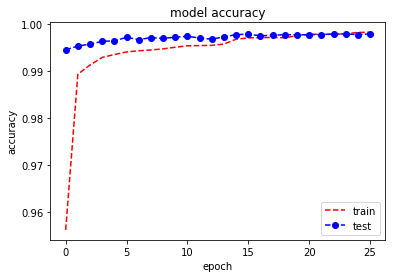

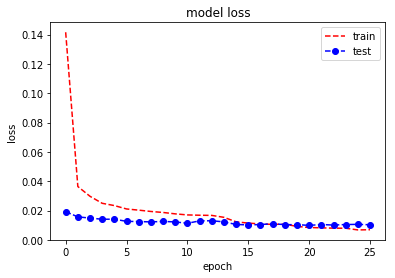

In [17]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'],'r--')
plt.plot(history.history['val_acc'], 'bo--')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],'r--')
plt.plot(history.history['val_loss'],'bo--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [18]:
# predict classes
preds_prob = model.predict(x_test, batch_size=512)

In [19]:
preds_prob.shape
preds = preds_prob.argmax(axis=-1)

In [20]:
print preds.shape

(40000,)


In [21]:
test_labels.shape

(40000,)

In [22]:
correct = np.where(preds==test_labels)[0]
incorrect = np.where(preds!=test_labels)[0]

In [23]:
print correct.shape
print incorrect.shape

(39916,)
(84,)


In [24]:
# number of images to view
n_view = incorrect.shape[0]

In [25]:
from numpy.random import permutation

# get a random selection of correctly predicted images
idx = permutation(correct)[:n_view]
idx_incorrect = permutation(incorrect)[:n_view]

In [26]:
preds_correct = preds[idx]
preds_incorrect = preds[idx_incorrect]

In [27]:
imgs = x_test[idx]
imgs_incorrect = x_test[idx_incorrect]

In [28]:
imgs.shape

(84, 1, 28, 28)

In [30]:
def lvling10class(x):
    if x==0:
        y= '0'
    elif x==1:
        y= '1'
    elif x==2:
        y= '2'
    elif x==3:
        y= '3'
    elif x==4:
        y= '4'
    elif x==5:
        y= '5'
    elif x==6:
        y= '6'
    elif x==7:
        y= '7'
    elif x==8:
        y= '8'
    elif x==9:
        y= '9'
    else :
        y= 'no level'
    
    return y

#testing leveling
result = lvling10class(preds_correct[0])
print result

0


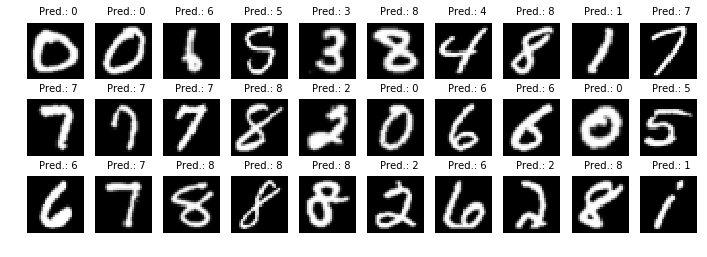

In [31]:
f = plt.figure(figsize=(12,4))

for i in range(30):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    #sp.set_title(preds_correct[i])
    sp.text(0.9, 1.2, "Pred.: {}"
                 .format(lvling10class(preds_correct[i])),
            horizontalalignment='right', verticalalignment='center',
            transform=sp.transAxes)
    img = imgs[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [32]:

# ground truth labels
test_labels[idx]

array([0, 0, 6, 5, 3, 8, 4, 8, 1, 7, 7, 7, 7, 8, 2, 0, 6, 6, 0, 5, 6, 7,
       8, 8, 8, 2, 6, 2, 8, 1, 6, 7, 1, 0, 6, 2, 2, 4, 7, 1, 7, 0, 4, 8,
       1, 0, 3, 5, 3, 7, 3, 9, 5, 1, 2, 6, 5, 4, 7, 5, 5, 4, 8, 2, 7, 1,
       0, 7, 6, 8, 3, 4, 6, 8, 3, 1, 4, 6, 1, 4, 7, 7, 9, 2], dtype=uint8)

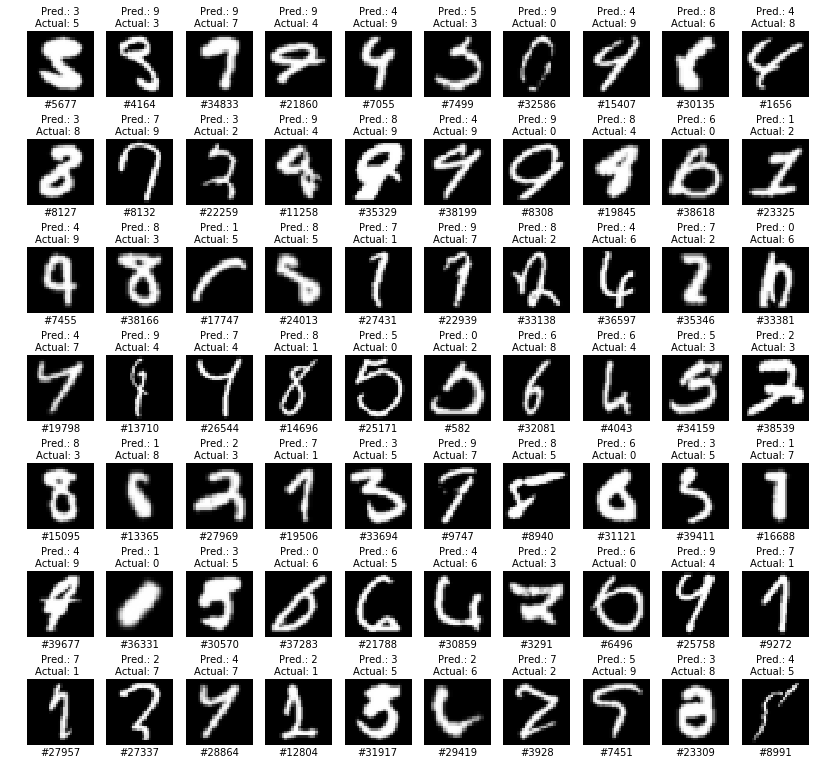

In [34]:
f = plt.figure(figsize=(14,10))

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.15,
                wspace=None, hspace=None)

for i in range(70): 
    sp = f.add_subplot(7, 10, i+1)
    sp.axis('Off')
    sp.text(0.8, 1.2, "Pred.: {}\nActual: {}"
                 .format(lvling10class(preds_incorrect[i]),lvling10class(test_labels[idx_incorrect][i])),
            horizontalalignment='right', verticalalignment='center',
            transform=sp.transAxes)
    plt.text(0.5, -0.12, "#{}".format(idx_incorrect[i]), 
             horizontalalignment='center', verticalalignment='center',
             transform=sp.transAxes)
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [35]:
# ground truth labels
test_labels[idx_incorrect]

array([5, 3, 7, 4, 9, 3, 0, 9, 6, 8, 8, 9, 2, 4, 9, 9, 0, 4, 0, 2, 9, 3,
       5, 5, 1, 7, 2, 6, 2, 6, 7, 4, 4, 1, 0, 2, 8, 4, 3, 3, 3, 8, 3, 1,
       5, 7, 5, 0, 5, 7, 9, 0, 5, 6, 5, 6, 3, 0, 4, 1, 1, 7, 7, 1, 5, 6,
       2, 9, 8, 5, 6, 9, 3, 1, 0, 9, 9, 4, 5, 7, 4, 4, 0, 3], dtype=uint8)

In [36]:
idx_incorrect

array([ 5677,  4164, 34833, 21860,  7055,  7499, 32586, 15407, 30135,
        1656,  8127,  8132, 22259, 11258, 35329, 38199,  8308, 19845,
       38618, 23325,  7455, 38166, 17747, 24013, 27431, 22939, 33138,
       36597, 35346, 33381, 19798, 13710, 26544, 14696, 25171,   582,
       32081,  4043, 34159, 38539, 15095, 13365, 27969, 19506, 33694,
        9747,  8940, 31121, 39411, 16688, 39677, 36331, 30570, 37283,
       21788, 30859,  3291,  6496, 25758,  9272, 27957, 27337, 28864,
       12804, 31917, 29419,  3928,  7451, 23309,  8991, 37044, 38503,
       21504,  6538, 11283, 31239, 35166, 10017, 18158,  9981,  7349,
        5421, 28894, 26046])

In [48]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_labels, preds)

In [49]:
import itertools

class_names = [i for i in range(10)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(50,50))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(50,50))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

NameError: global name 'matplotlib' is not defined

<Figure size 3600x3600 with 0 Axes>